<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/notebooks/tutorials/Constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parameters often have constraints, such as $x > 0$ or $0 < x < 2 \pi$. This notebook demonstrates how to impose such constraints in MCHMC code.

**Note**: uniform priors, such as $x \sim U(0.1, 3)$ are often used unneccesarily and a smooth prior, such as a Gaussian would be more appropriate. Are we really absolutely certain that x cannot be 0.09?

There are two approaches that we can take to constraint the parameters:

- impose reflective (or periodic) boundaries
- transform the parameters

The first approach is implemented in MCHMC.
The second approach currently needs to be done by hand.

We will try both strategies in this notebook.
Let's do some imports:

In [ ]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from MicroCanonicalHMC.mclmc.sampler import Sampler
from MicroCanonicalHMC.mclmc.boundary import Boundary

We will sample from two toy distributions:

1. Distribution with first two parameters positive:

$$ x_1, x_2 \sim Exp(\lambda = 1) $$
$$ x_3, \ldots x_d \sim N(0, 1) $$



2. Distribution with first parameter an angle between 0 and $2 \pi$, second two parameters between 0 and 1 and fourth parameter positive:

$$p(x_0) \propto \exp \{ 5 \cos{x_0} \}$$
$$x_1 \sim \beta(5, 1)$$
$$x_2 \sim \beta(2, 2)$$
$$ x_3 \sim Exp(\lambda = 1)$$
$$ x_4, \ldots x_d \sim N(0, 1) $$

# Distribution 1

### Approach 1: transform the parameters

The first approach we will take is to transform the parameters.
We will work with the parameter vector:
$$\boldsymbol{z} = (\log x_1,\, \log x_2,\, x_3,\, \ldots x_d)$$
Note that $z_1 \in \mathbb{R}$ is not constrained anymore, so we have managed to make the parameter space unconstrained.

We shouldn't forget to also transform the density:

$$\log p(z_1) = \log p(x_1(z_1))  + \log \bigg{\vert} \frac{d x_1}{d z_1} \bigg{\vert} = \log (p(e^{z_1})) + z_1 $$

Since the original density was $p(x_1) = \lambda e^{-\lambda x_1}$, we get

$$\log p(z_1) = - \lambda e^{z_1} + \log \lambda + z_1$$.

Let's implement the target:

In [4]:
nlogp = lambda z: jnp.sum(jnp.exp(z[:2]) - z[:2]) + 0.5 * jnp.sum(jnp.square(z[2:])) # we have dropped the constant log lambda term.


class TransformedTarget():

    def __init__(self, d):
        self.d = d
        self.nlogp = nlogp
        self.grad_nlogp = jax.value_and_grad(self.nlogp)
        self.transform = lambda x: x
        self.prior_draw = lambda key: jnp.abs(jax.random.normal(key, shape = (self.d, )))

target = TransformedTarget(d= 50)

Let's do sampling in the transformed space and transform back at the end:

In [5]:
sampler = Sampler(target)

z = sampler.sample(10000)
x1 = jnp.exp(z[:, 0])
x2 = jnp.exp(z[:, 0])
x3 = z[:, 2]
# ...

Let's visualize the results:

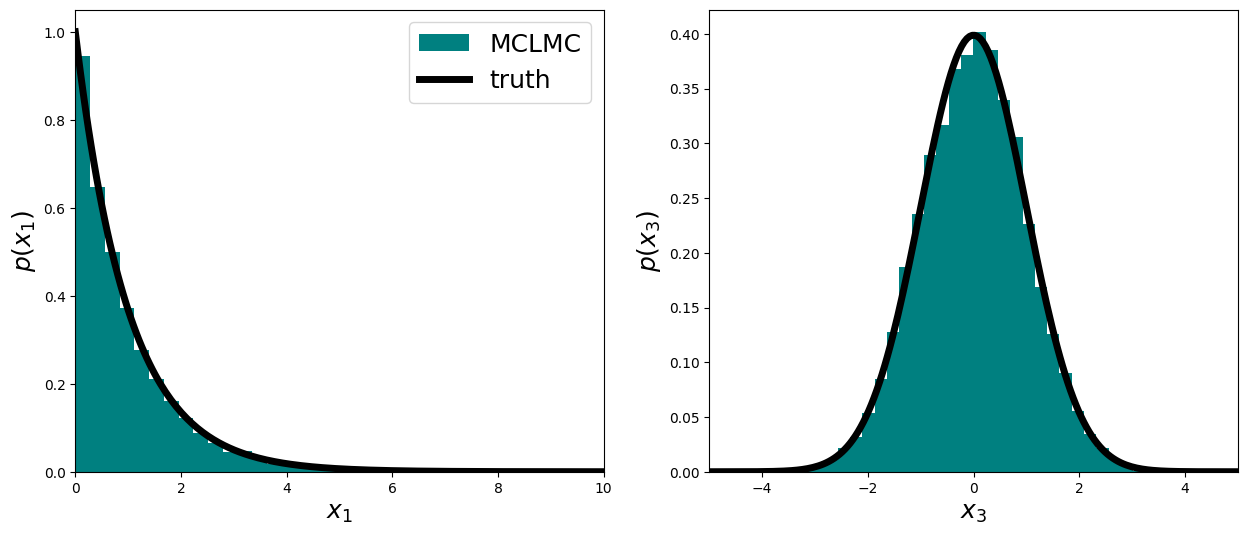

In [6]:
def visualize_results(x1, x3):

    plt.figure(figsize = (15, 6))

    # x_1
    plt.subplot(1, 2, 1)
    plt.hist(x1, bins = 30, density = True, color = 'teal', label = 'MCLMC')
    t = jnp.linspace(0, 10, 200)
    plt.plot(t, jnp.exp(-t), color = 'black', lw = 5, label = 'truth')
    plt.xlabel(r'$x_1$', fontsize = 18)
    plt.ylabel(r'$p(x_1)$', fontsize = 18)
    plt.xlim(0, 10)
    plt.legend(fontsize = 18)


    # x_3
    plt.subplot(1, 2, 2)
    plt.hist(x3, bins = 30, density = True, color = 'teal', label = 'MCLMC (transformed target)')
    t = jnp.linspace(-5, 5, 200)
    plt.plot(t, jnp.exp(-0.5 * jnp.square(t)) / jnp.sqrt(2 * jnp.pi), color = 'black', lw = 5, label = 'truth')
    plt.xlim(-5, 5)
    plt.xlabel(r'$x_3$', fontsize = 18)
    plt.ylabel(r'$p(x_3)$', fontsize = 18)

    plt.show()

visualize_results(x1, x3)

### Approach 2: Reflective boundary

Alternatively, we can use the reflecitve boundary in the dynamics.
We define the untransformed target:

In [7]:
nlogp = lambda x: jnp.sum(x[:2]) + 0.5 * jnp.sum(jnp.square(x[2:])) # we have dropped the constant log lambda term.

class Target():

    def __init__(self, d):
        self.d = d
        self.nlogp = nlogp
        self.grad_nlogp = jax.value_and_grad(self.nlogp)
        self.transform = lambda x: x
        self.prior_draw = lambda key: jnp.abs(jax.random.normal(key, shape = (self.d, )))

target = Target(d= 50)

And impose the constraints with the Boundary object (we pass it the indices of the parameters which are constrained):

In [8]:
boundary = Boundary(target.d, where_positive = jnp.array([0, 1])) #x0 and x1 are positive

Let's do the sampling and visualize the results:

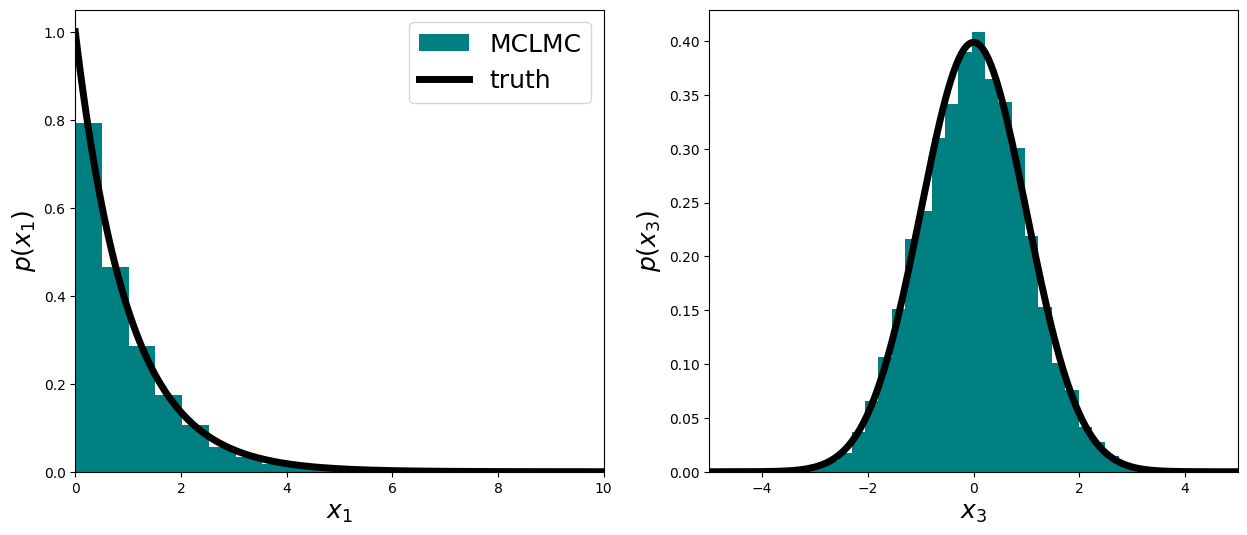

In [9]:
sampler = Sampler(target, boundary = boundary)
x = sampler.sample(10000)
visualize_results(x[:, 0], x[:, 2])

# Distribution 2

We will now sample from


$$p(x_0) \propto \exp \{ 5 \cos{x_0} \}$$
$$x_1 \sim \beta(5, 1)$$
$$x_2 \sim \beta(2, 2)$$
$$ x_3 \sim Exp(\lambda = 1)$$
$$ x_4, \ldots x_d \sim N(0, 1) $$


We could again tranform our domain to $\mathbb{R}^d$, using for example logit transform, tangens or arctanh functions for the first three parameters.

However, we will here impose the constraints with reflective and periodic boundaries.

Let's implement the target:

In [77]:
nlogp_beta = lambda x, alpha, beta: -(alpha-1.) * jnp.log(x) - (beta-1.) * jnp.log(1.-x)

nlogp = lambda x: -5 * jnp.cos(x[0]) + nlogp_beta(x[1], 5., 1.) + nlogp_beta(x[2], 2., 2.) + x[3] + 0.5 * jnp.sum(jnp.square(x[4:]))

class Target():

    def __init__(self, d):
        self.d = d
        self.nlogp = nlogp
        self.grad_nlogp = jax.value_and_grad(self.nlogp)
        self.transform = lambda x: x

    def prior_draw(self, key):
        key1, key2 = jax.random.split(key, 2)
        u = jax.random.uniform(key1, shape = (3, ))
        z = jax.random.normal(key2, shape = (self.d-3, ))
        return jnp.concatenate((u, z))

target = Target(d= 100)

We will use reflective boundary conditions for $x_1$ and $x_2$, periodic boundary conditions for $x_0$ and positive constraint for $x_3$:

In [78]:
boundary = Boundary(target.d,
                    where_periodic = jnp.array([0, ]),
                    where_reflect = jnp.array([1, 2]),
                    where_positive = jnp.array([3, ]),
                    a = jnp.array([0., 0., 0.]),
                    b = jnp.array([2 * jnp.pi, 1., 1.]))

Particle bounces off the reflective boundary.
If the domain is periodically connected (meaning that $p(x)$ and its derivatives do not have a jump when going from $x = b$ to $x = a$), the periodic boundary conditions are more appropriate. We therefore use periodic boundary conditions for $x_0$.

Let's do the sampling and visualize the results (we use diagonal preconditioning because the first four parameters have different scales than the other parameters):

In [ ]:
sampler = Sampler(target, boundary = boundary, diagonal_preconditioning = True)
x = sampler.sample(100000)

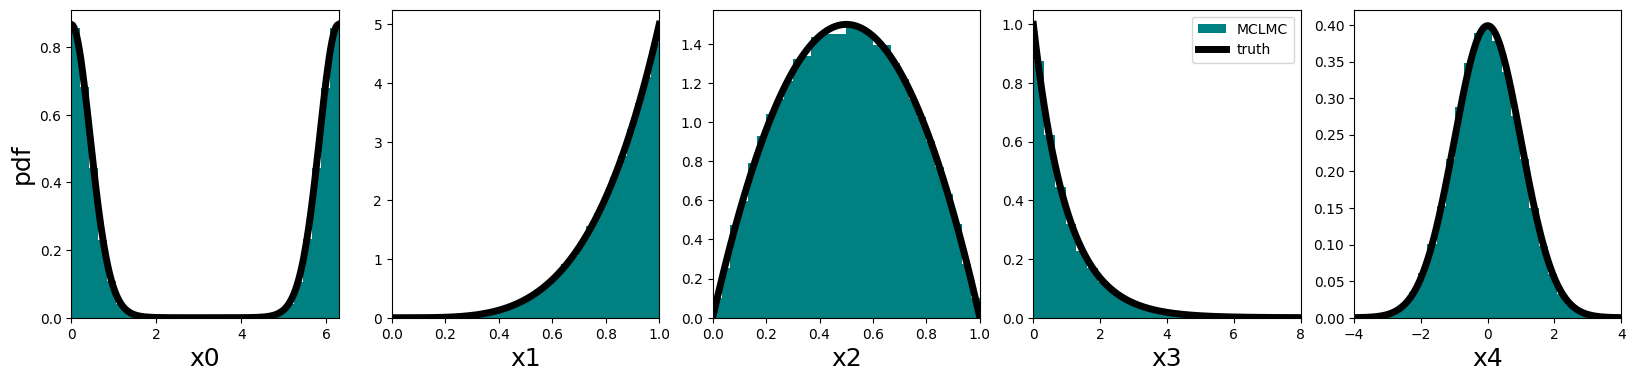

In [81]:
plt.figure(figsize = (20, 4))

a = [0, 0, 0, 0, -4]
b = [2 * jnp.pi, 1, 1, 8, 4]
truth = [lambda t: jnp.exp(5 * jnp.cos(t)) / 171.153,
         lambda t: jnp.power(t, 4) * 5,
         lambda t: t*(1-t)*6.,
         lambda t: jnp.exp(-t),
         lambda t: jnp.exp(-0.5 * jnp.square(t)) / jnp.sqrt(2 * jnp.pi)]


for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.hist(x[:, i], bins = 30, density = True, color = 'teal', label = 'MCLMC')
    t = jnp.linspace(a[i], b[i], 200)
    plt.plot(t, truth[i](t), color = 'black', lw = 5, label = 'truth')
    plt.xlabel('x' + str(i), fontsize = 18)
    if i == 0:
        plt.ylabel('pdf', fontsize = 18)
    plt.xlim(a[i], b[i])
    if i == 3:
        plt.legend()

plt.show()